### Importing Libraries

In [1]:
import cv2
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

### Reading Image

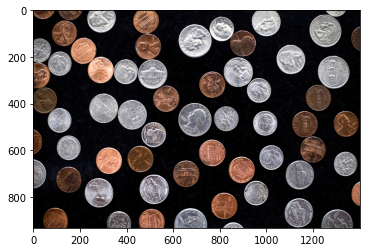

In [2]:
img = iio.imread("im03.jpg")
plt.imshow(img);

def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255

### Getting Edges
##### For getting edges first I filtered image to get rid of unwanted detailes, then I changed color space to HSV and just used vibrance,
##### after all I used canny edge detector to cumpute edges which could be seen down below

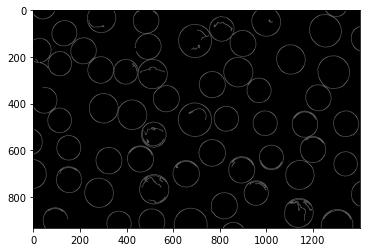

In [3]:
img_g = gaussian_filter(img, sigma=1.5)
img_g = cv2.cvtColor(img_g,cv2.COLOR_RGB2HSV)[:,:,2]
edges = cv2.Canny(image=img_g, threshold1=90, threshold2=360) # Canny Edge 
plt.imshow(edges,cmap='gray');
iio.imwrite("q2/res11.jpg",edges)
#edges3 = np.dstack((edges,0*edges,edges)).astype("uint8")
#plt.imshow(20*edges3+img//8,cmap='gray');

#### c3's value and result matrix 

In [4]:
c = [51,55,61,65,70]
h,w = edges.shape
print(h,w,len(c))
result = np.zeros((h,w,len(c)))

933 1400 5


### Hough transform (circle detection)
##### I draw a circle around each point of edge

In [5]:
def circle_hough(img,r):
    out = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j]:
                out = set_circle(out,i,j,r)
    return out
def set_circle(img,x,y,r): #add needed circle to img
    out = img.copy()
    N = int(2*np.pi*r)
    for i_n in range(N):
        theta = 2*np.pi*i_n/N
        i = int(x + r*np.cos(theta))
        j = int(y + r*np.sin(theta))
        if i>0 and j>0 and i<img.shape[0] and j<img.shape[1]:
            out[i,j] += 1
    return out

#### run hough on radiouses

In [7]:
for i in range(len(c)):
    c3 = c[i]
    print(c3)
    result[:,:,i] = circle_hough(edges,c3)

51
55
61
65
70


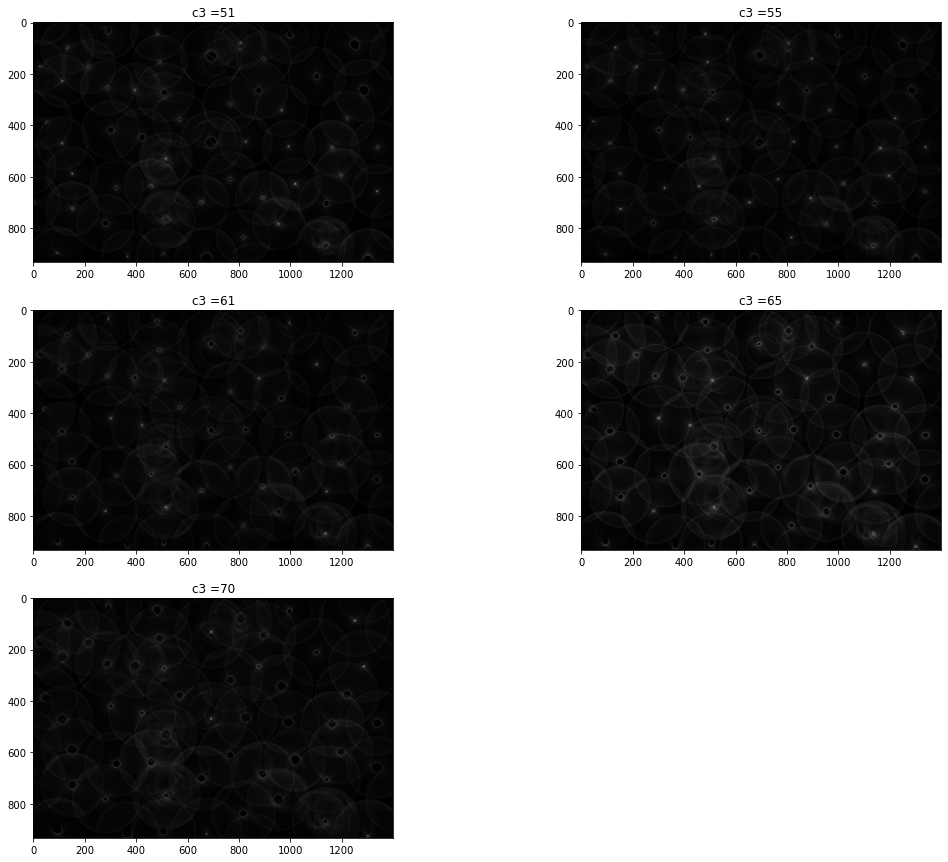

In [8]:
plt.figure(figsize=(18,15))
for i in range(len(c)):
    plt.subplot(3,2,1+i)
    plt.imshow(result[:,:,i],cmap='gray');
    plt.title('c3 ='+str(c[i]))

#### setting thresholds and filter to get one point,
#### after that I used another gaussing filter to get some points that has best one in the middle, and I filterd it in the next section

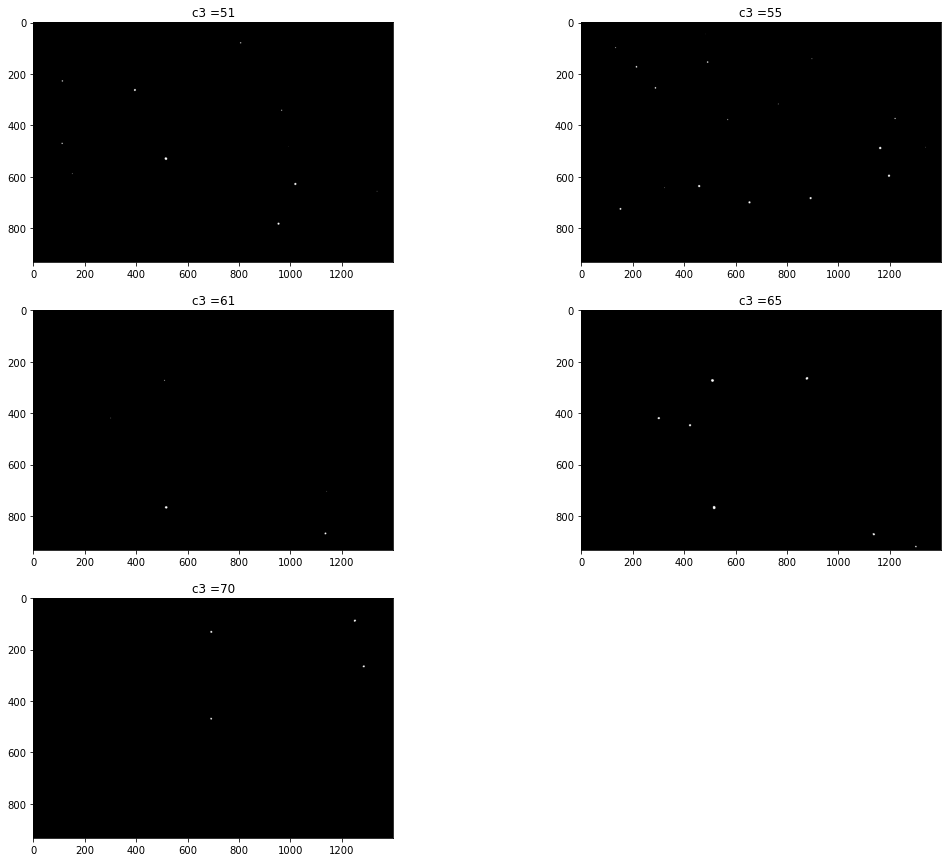

In [46]:
plt.figure(figsize=(18,15))
result_g = np.zeros(result.shape)
thr = [140,140,150,150,150]
for i in range(len(c)):
    result_g[:,:,i] = scale(gaussian_filter(scale(result[:,:,i]), sigma=2))
    result_g[:,:,i] = result_g[:,:,i]>thr[i]
    result_g[:,:,i] = scale(gaussian_filter(scale(result_g[:,:,i]), sigma=3))
    result_g[:,:,i] = result_g[:,:,i]>thr[i]/1
    plt.subplot(3,2,1+i)
    plt.imshow(result_g[:,:,i],cmap='gray');
    plt.title('c3 ='+str(c[i]))

#### this function gets the brigtest pixel, so it makes a full filled circle to a line, by setting the maximum point to one in a s x s window

In [47]:
def get_center(img,s=30):
    out = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] :
                if i>s and j>s:
                    window = img[i-s:i+s,j-s:j+s]
                    max_loc = np.array(np.where(window==np.max(window))).flatten()
                    out[i-s+max_loc[0],j-s+max_loc[1]] = 1
                elif j>s:
                    window = img[0:i+s,j-s:j+s]
                    max_loc = np.array(np.where(window==np.max(window))).flatten()
                    out[max_loc[0],j-s+max_loc[1]] = 1
                elif i>2 and j>2 :
                    window = img[0:i+s,0:j+s]
                    max_loc = np.array(np.where(window==np.max(window))).flatten()
                    out[max_loc[0],max_loc[1]] = 1
    return out     

##### I calculated centers by geting horizintal and vertical diameters of circle and center is the overlap

11.0
17.0
5.0
7.0
4.0


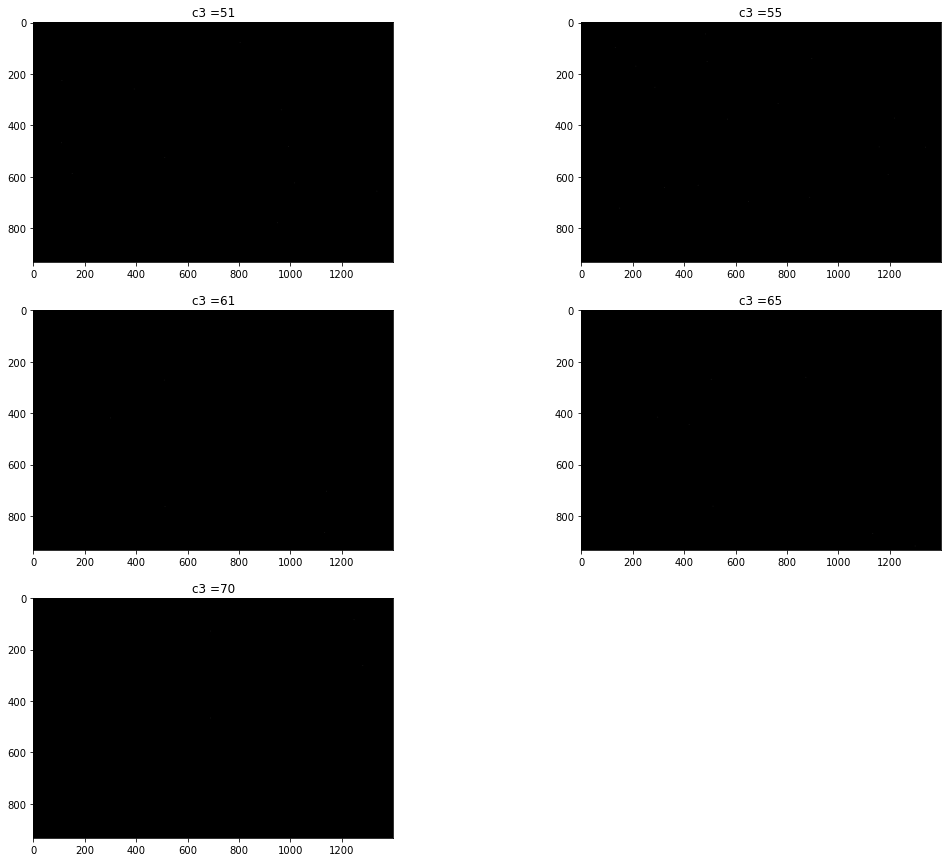

In [48]:
plt.figure(figsize=(18,15))
centers = np.zeros(result_g.shape)
for i in range(len(c)):
    plt.subplot(3,2,1+i)
    centers[:,:,i] = get_center(result_g[:,:,i].T).T * get_center(result_g[:,:,i])
    print(np.sum(np.sum(centers[:,:,i])))
    plt.imshow(centers[:,:,i],cmap='gray');
    plt.title('c3 ='+str(c[i]))

##### this function helps to not draw one circle twice

In [55]:
def is_again(drawd,i,j,delta=10**2):
    if len(drawd)==0: return False
    for i in range(len(drawd)):
        x = drawd[i][0]
        y = drawd[i][1]
        if (i-x)**2+(j-y)**2<delta:
            return True
    return False

#### drawing circles

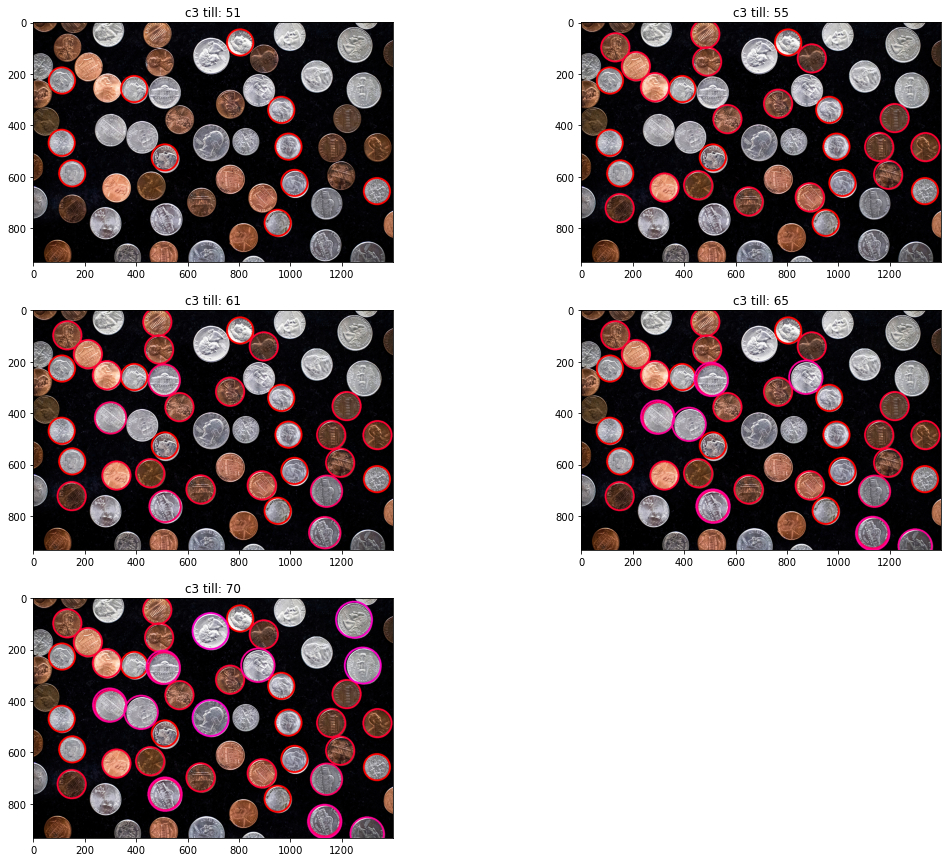

In [56]:
img = iio.imread("im03.jpg")
plt.figure(figsize=(18,15))
drawd = []

for i_m in range(len(c)):
    temp = centers[:,:,i_m]
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if temp[i,j] and not(is_again(drawd,i,j)):
                drawd.append((i,j))
                img = cv2.circle(img, (j,i), c[i_m], (255, 0, i_m*50), 5)
    plt.subplot(3,2,1+i_m)
    plt.imshow(img,cmap='gray');
    plt.title('c3 till: '+str(c[i_m]))


circles drawed 44


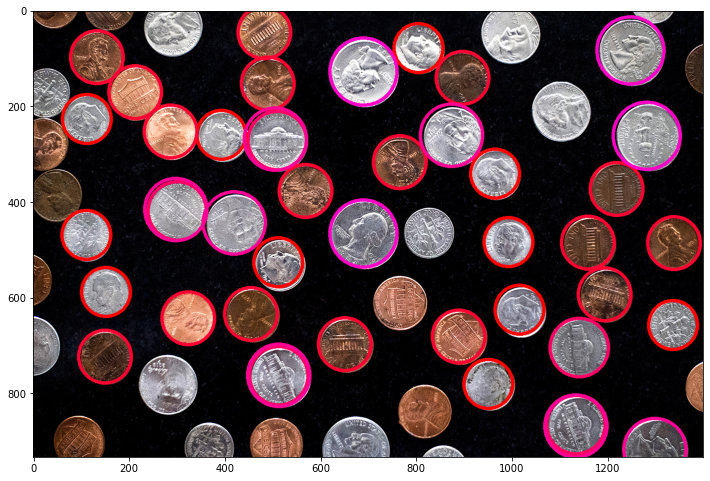

In [57]:
iio.imwrite("q2/res12-circles.jpg",img)
print("circles drawed",len(drawd))
plt.figure(figsize=(12,12))
plt.imshow(img);